In [68]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [69]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

<h4>Build model and get teh influence points<h4>

In [70]:
dataset = 'german'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [71]:
X_train, X_test, y_train, y_test = load(dataset)

In [72]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [73]:
len(X_train)

800

In [74]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [75]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [76]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.09527579839341338
Initial TPR parity:  -0.07785149414194836
Initial predictive parity:  -0.10136869475949661
Initial accuracy:  0.755


<h4>Calculate Influence of original datapoints with original labels<h4>

In [77]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [78]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:12<00:00, 65.50it/s]


In [79]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [80]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [81]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [82]:
inf=(1/len(X_train))*(inf)

In [83]:
print(min(inf))
print(max(inf))

-0.005975094170870934
0.003204487974823138


<h4>Calculate the inf for the datapoints with a changed label using del_L_del_theta_i<h4>

In [84]:
#Use the same info from the previous section but with the labels changed
#Original Four datasets
X_test#scaled
X_train#scaled
X_test_orig#encoded
X_test_orig#encoded

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,...,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,housing_A151,housing_A152,housing_A153
0,1,1,3,2,1,0,1,0,2,2,...,False,False,False,False,False,False,False,False,True,False
1,0,2,2,2,0,0,2,1,3,1,...,False,False,False,False,False,False,False,False,True,False
2,3,0,4,1,0,4,2,0,4,2,...,True,False,False,False,False,False,False,False,True,False
3,0,2,2,1,0,4,4,0,2,1,...,True,False,False,False,False,False,False,False,True,False
4,0,3,4,1,0,4,3,0,4,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3,0,2,1,0,3,1,0,4,3,...,False,False,False,False,False,False,True,False,True,False
196,0,0,2,1,0,2,2,1,2,2,...,True,False,False,False,False,False,False,False,True,False
197,3,0,0,0,4,3,4,0,4,3,...,False,False,False,True,False,False,False,False,True,False
198,3,1,2,1,0,1,4,0,1,3,...,False,True,False,False,False,False,False,False,True,False


In [85]:
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
y_test_changed = y_test.replace({0:1,1:0})

In [86]:
#Instead of flipping everything before iteratively move through the dataset and calculate del_L_del_i


In [87]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [88]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test_changed, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.09501853685360401
Initial TPR parity:  0.06228146450046229
Initial predictive parity:  0.10818301552416582
Initial accuracy:  0.755


In [89]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test_changed, dataset, metric)

In [90]:
# Convert numpy array to tensorflow tensor
import torch 
tensor_train_attr = torch.Tensor(X_train)
tensor_train_label = torch.Tensor(y_train_changed)

In [91]:
tensor_train_label = tensor_train_label.type(torch.float64)
tensor_train_attr = tensor_train_attr.type(torch.float64)

In [92]:
del_L_del_i = []
for i in range(int(len(X_train))):
    gradient = convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], int(y_train_changed[i]), loss_func))
    del_L_del_i.append(gradient)

In [93]:
del_L_del_i = np.array(del_L_del_i)

In [94]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:12<00:00, 65.52it/s]


In [95]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [96]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_i))
#incorporate del_l_del_theta_i with the updated datapoint

In [97]:
inf2 = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [98]:
inf2 = (1/len(X_train))*(inf2)

In [99]:
print(min(inf2))
print(max(inf2))

-0.003213448287634082
0.005969755902279662


<h4>Calculate the inf for the datapoints with the changed label using the original method<h4>

In [100]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test_changed, dataset, metric)

In [101]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:12<00:00, 65.15it/s]


In [102]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [103]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))

In [104]:
inf3 = np.matmul(np.transpose(hinv_v), del_F_del_theta)

In [105]:
inf3 = (1/len(X_train))*(inf3)

In [106]:
print(min(inf3))
print(max(inf3))

-0.003213448287634082
0.005969755902279662


In [107]:
#Check to see if the influences are correct by graphing the predicted vs the actual fairness similar to the paper
    #Check this for the OG datapoints not the changed labels
#Also make a cleaner version of this notebook for dr. pradhan to check
    #Keep just information about the influence functions and removing datapoints rather than information about flipping 
    #Take a copy and make the changes
#Use computeFairness() for testing for parity

<h4>Calculate the difference between the changed vs original<h4>

In [108]:
total_inf = inf2-inf

In [109]:
print(max(total_inf))
print(min(total_inf))
print(len(total_inf))
print(type(total_inf))
print(total_inf.dtype)

0.011944850073150597
-0.00641793626245722
800
<class 'numpy.ndarray'>
float64


<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [110]:
predictors = ['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'gender', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'housing_A151', 'housing_A152', 'housing_A153']
target_var =['credit_risk']

In [111]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('credit_risk')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['credit_risk'] = changed_df_labels

    return y_predicted


In [112]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [113]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    print(parity)

    difference.append(parity-spd_0)


-0.09558855076320472
-0.09404617575928576
-0.0948285352438688
-0.09531784979626534
-0.09437453229911619
-0.09483948065899306
-0.09489936395548282
-0.09496816904284056
-0.096138657676056
-0.09423134238459163
-0.09514549653977156
-0.09475383888930078
-0.09600602583959694
-0.09688017019070683
-0.0938391156028956
-0.09385844613425431
-0.0941971390973777
-0.09395532677881413
-0.09644823330454522
-0.09511663718149066
-0.0959430115763098
-0.0956374539993704
-0.09446451771073039
-0.09523196881636975
-0.09564706711098558
-0.09398591592907912
-0.09563918877393007
-0.09389369459822772
-0.09563542921096091
-0.09502340769395234
-0.09470957955345516
-0.09540311838500204
-0.09497806392610075
-0.09333473760634659
-0.09572067400440576
-0.09497866421006618
-0.0953302130103112
-0.09363563465885816
-0.09401394003070895
-0.09501161589287221
-0.09435730930417774
-0.09487848407588895
-0.09352812278084466
-0.09402239313349126
-0.09477418949827554
-0.09502092530019579
-0.09625265076756484
-0.09356398601084948


In [114]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[-0.0001350161, 0.0007689151, 1.468e-06, -0.0004601497, 0.0004579974, -1.5055e-06, -6.41949e-05, -0.0001304815, -0.0012377489, 0.0005813503, -0.0002946993, 7.63424e-05, -0.0011414374, -0.001858289, 0.0009743028, 0.0009411389, 0.0006241242, 0.0008615548, -0.0015670895, -0.000278972, -0.0010752921, -0.0007589532, 0.0003648374, -0.0003838773, -0.0006934423, 0.0008288297, -0.0007814517, 0.0009263216, -0.0007694597, -0.0001842594, 0.0001243821, -0.0005587321, -0.0001397267, 0.0014771749, -0.0008536602, -0.0001388449, -0.0004821032, 0.0011374723, 0.0008044177, -0.0001802059, 0.0004345539, -3.75049e-05, 0.0012635428, 0.0007711644, 6.91594e-05, -0.0001815898, -0.0013354056, 0.0012204247, 7.2261e-06, -6.62973e-05, -0.0002172353, -6.24262e-05, -0.0029064492, -0.0013223234, -0.0006591325, -0.000135914, -0.0003290167, 0.0011758743, -0.00065706, -0.0002498615, -7.13334e-05, -6.9873e-05, 0.0004087943, 0.0003963535, 0.0009018029, -6.7238e-06, -0.0010662154, -0.0003458889, -4.15909e-05, -0.0001205018,

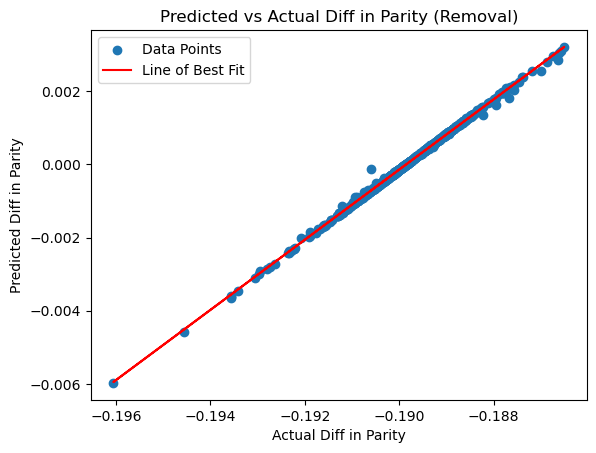

In [115]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Calculate the line of best fit
m, b = np.polyfit(actual_diff, predicted_diff, 1)

# Plot the line of best fit
plt.plot(actual_diff, m*np.array(actual_diff) + b, color='red', label='Line of Best Fit')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>##########################################################################################<h3>

<h4>Make flips based on the total_inf value<h4>

In [116]:
index_list = []
for i in range(800):
    index_list.append(i)


In [117]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [118]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(total_inf, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)

[198,
 423,
 597,
 690,
 553,
 652,
 342,
 506,
 429,
 636,
 770,
 252,
 52,
 376,
 350,
 374,
 405,
 161,
 796,
 349,
 386,
 289,
 233,
 241,
 739,
 231,
 89,
 398,
 620,
 196,
 354,
 598,
 330,
 608,
 266,
 430,
 732,
 238,
 547,
 202,
 626,
 792,
 505,
 390,
 428,
 508,
 13,
 371,
 524,
 694,
 104,
 242,
 542,
 444,
 473,
 487,
 695,
 716,
 697,
 80,
 757,
 462,
 469,
 163,
 18,
 175,
 475,
 239,
 338,
 378,
 737,
 133,
 33,
 701,
 265,
 215,
 412,
 672,
 479,
 112,
 230,
 344,
 185,
 328,
 76,
 772,
 268,
 247,
 530,
 301,
 46,
 771,
 122,
 282,
 353,
 748,
 53,
 319,
 359,
 671,
 522,
 287,
 146,
 610,
 129,
 567,
 42,
 356,
 725,
 526,
 367,
 8,
 552,
 167,
 47,
 130,
 296,
 696,
 275,
 232,
 503,
 432,
 57,
 102,
 326,
 680,
 298,
 604,
 668,
 586,
 12,
 37,
 272,
 292,
 682,
 120,
 83,
 675,
 340,
 98,
 740,
 588,
 618,
 20,
 333,
 66,
 116,
 224,
 632,
 450,
 639,
 192,
 778,
 661,
 126,
 313,
 585,
 470,
 134,
 720,
 640,
 691,
 744,
 314,
 537,
 14,
 782,
 548,
 595,
 556,
 

In [119]:
'''

    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)

'''
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'credit_risk'] == 1:
        influence_train_copy.at[row_num,'credit_risk'] = 0
        #copy_train_df = train_full_df.copy()
        #accuracy, test_demo_df, predicted_df = logistic_regression_updated(influence_train_copy, X_test_orig, y_test, predictors,'credit_risk_12')
        #parity = s_parity(X_test_orig , predictors, y_test, 'age', 1, 'credit_risk_12')
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'credit_risk'] == 0:
        influence_train_copy.at[row_num,'credit_risk'] = 1
        #copy_train_df = train_full_df.copy()
        #accuracy, test_demo_df, predicted_df = logistic_regression_updated(influence_train_copy, X_test_orig, y_test, predictors,'credit_risk_12')
        #parity = s_parity(test_demo_df, predictors, predicted_df, 'age', 1, 'credit_risk_12')
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
print(flip_parity_abs)

[-0.10217929775826629, -0.10753714828751981, -0.11207302613183856, -0.11622928818687794, -0.12125293579883867, -0.12659075665287667, -0.12146632582880557, -0.11644867723807695, -0.12104142778553073, -0.11648934441618619, -0.12095326622948044, -0.11600848110392692, -0.11992156892083583, -0.11489752978086465, -0.1190728436689823, -0.1138976295478642, -0.11768810525536533, -0.1224988899659365, -0.11609310787171123, -0.11294396608136592, -0.11619227537885313, -0.1210963354911655, -0.11697704186663027, -0.11235623923130333, -0.11716358293779194, -0.12069159294478593, -0.12367278970777995, -0.12866318263113496, -0.13226142940111452, -0.12754662926308813, -0.12188710942864411, -0.11724128196947281, -0.1143254173453897, -0.11111117335967713, -0.10591281671077013, -0.1011289143469184, -0.10429659164510663, -0.10836032391525807, -0.10556697850115593, -0.09946359903551638, -0.1039733923971653, -0.10118115977384157, -0.09581840769387773, -0.0916045494843275, -0.08911148435436189, -0.09173081549815

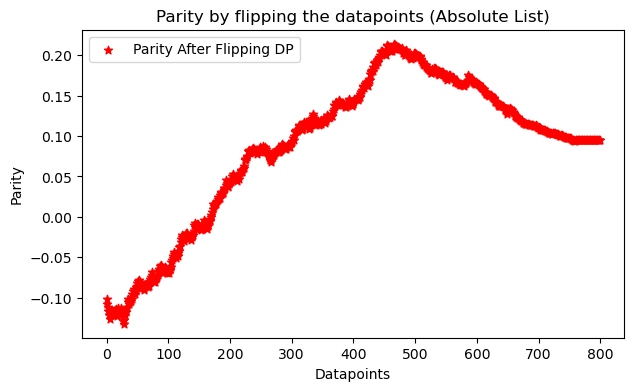

In [120]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='red', label='Parity After Flipping DP', marker='*')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

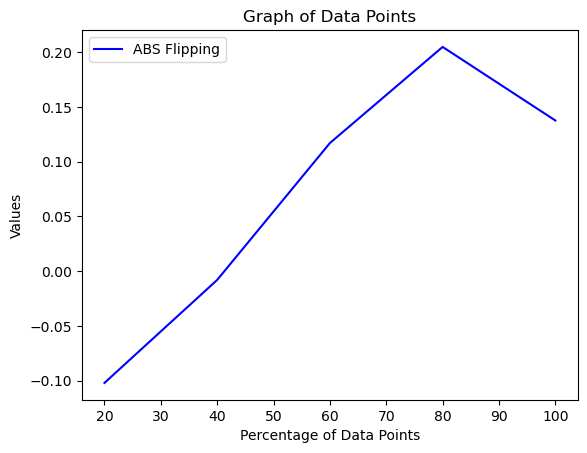

In [121]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
#plt.plot([20, 40, 60, 80, 100], values_non_abs, label='Non-ABS Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()